# HO-FMN: Hyperparameter Optimization for Fast Minimum-Norm Attacks

## Manually install the requirements

In [ ]:
!pip install ax-platform
!pip install ax-platform[mysql]
!pip install sqlalchemy==1.4.50
!pip install git+https://github.com/RobustBench/robustbench.git

In [2]:
import torch
from torch.utils.data import DataLoader

from src.ho_fmn.ho_fmn import HOFMN
from src.attacks.fmn import FMN
from src.utils.model_data import load_data
from src.utils.show_image import show_image

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Setup HO-FMN
Download the model to attack from the Robustbench models' ZOO and download and prepare the dataloader; in this demo we use the CIFAR10 dataset.

In [ ]:
model_id = 8
batch_size = 64

model, dataset, model_name, _ = load_data(model_id=model_id)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False
)

HO-FMN works by running multiple FMN attacks for each tuning trial, and the optimization metric is the median distance of the best adversarial found; the custom FMN version is identified by the triplet (loss, optimizer, scheduler). Respectively, these losses, optimimzers and schedulers are available:
- losses: LL, DLR, CE
- optimizers: SGD, Adam, Adamax
- schedulers: CALR (CosineAnnealingLR), RLROP (Reduce Learning Rate on Plateau)

Usually Adam and Adamax do not require the use of scheduler since their algorithms include automatic steps size tuning.

HO-FMN leverage the Ax Hyperparameter Tuning Framework (by Meta), which uses Bayesian Optimization for exploring the search space. The tuning consists of N trials, in which a set of hyperparameters is samples according to the optimization strategy. For this demo 32 trials have been selected, which means that 32 FMN attacks of 100 steps will be run. The number of samples used for the tuning are TUNING_SAMPLES = trials * batch_size.

In [41]:
loss = 'DLR'          # losses: LL, DLR, CE
optimizer = 'SGD'     # optimizers: SGD, Adam, Adamax
scheduler = 'RLROP'   # schedulers: CALR, RLROP

steps = 100           # The number of FMN attack iterations
trials = 32           # Number of HO optimization trials

ho_fmn = HOFMN(
    model=model,
    dataloader=dataloader,
    loss=loss,
    optimizer=optimizer,
    scheduler=scheduler,
    steps=steps,
    trials=trials,
    verbose=True,
    device=device
)

To start the tuning process it is sufficient to run the next cell. We will see the samples hyperparameters at each trial, and the value of the objective metric (median distance). At the end of the optimization the parameters which resulted in the minimum distance value will be printed.

In [42]:
best_parameters = ho_fmn.tune()
print(f"Best parameters:\n{best_parameters}")

[INFO 02-26 15:13:37] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
/usr/local/lib/python3.10/dist-packages/ax/core/parameter.py:518: UserWarning:

`is_ordered` is not specified for `ChoiceParameter` "patience". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction.

/usr/local/lib/python3.10/dist-packages/ax/core/parameter.py:518: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "patience". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

[INFO 02-26 15:13:37] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FL

	[Tuning] Creating the Ax client and experiment...
	[Tuning] Starting the Hyperparameters Optimization...
	[Tuning] Running trial 0


[INFO 02-26 15:13:39] ax.service.ax_client: Completed trial 0 with data: {'distance': (0.063941, 0.0)}.
[INFO 02-26 15:13:39] ax.service.ax_client: Generated new trial 1 with parameters {'lr': 1.092872, 'momentum': 0.683326, 'weight_decay': 0.986258, 'dampening': 0.042295, 'factor': 0.407171, 'patience': 10, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.


	[Tuning] Running trial 1


[INFO 02-26 15:13:42] ax.service.ax_client: Completed trial 1 with data: {'distance': (0.088447, 0.0)}.
[INFO 02-26 15:13:42] ax.service.ax_client: Generated new trial 2 with parameters {'lr': 3.148531, 'momentum': 0.006239, 'weight_decay': 0.517772, 'dampening': 0.022877, 'factor': 0.49325, 'patience': 2, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.


	[Tuning] Running trial 2


[INFO 02-26 15:13:45] ax.service.ax_client: Completed trial 2 with data: {'distance': (0.127245, 0.0)}.
[INFO 02-26 15:13:45] ax.service.ax_client: Generated new trial 3 with parameters {'lr': 0.088535, 'momentum': 0.578866, 'weight_decay': 0.786929, 'dampening': 0.004382, 'factor': 0.193273, 'patience': 10, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.


	[Tuning] Running trial 3


[INFO 02-26 15:13:48] ax.service.ax_client: Completed trial 3 with data: {'distance': (0.045649, 0.0)}.
[INFO 02-26 15:13:48] ax.service.ax_client: Generated new trial 4 with parameters {'lr': 0.249754, 'momentum': 0.773681, 'weight_decay': 0.951349, 'dampening': 0.163111, 'factor': 0.397061, 'patience': 2, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.


	[Tuning] Running trial 4


[INFO 02-26 15:13:50] ax.service.ax_client: Completed trial 4 with data: {'distance': (0.054807, 0.0)}.
[INFO 02-26 15:13:50] ax.service.ax_client: Generated new trial 5 with parameters {'lr': 7.055996, 'momentum': 0.005057, 'weight_decay': 0.97228, 'dampening': 0.049891, 'factor': 0.23679, 'patience': 10, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.


	[Tuning] Running trial 5


[INFO 02-26 15:13:53] ax.service.ax_client: Completed trial 5 with data: {'distance': (0.140828, 0.0)}.
[INFO 02-26 15:13:53] ax.service.ax_client: Generated new trial 6 with parameters {'lr': 0.226365, 'momentum': 0.471448, 'weight_decay': 0.059124, 'dampening': 0.044534, 'factor': 0.483443, 'patience': 2, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.


	[Tuning] Running trial 6


[INFO 02-26 15:13:56] ax.service.ax_client: Completed trial 6 with data: {'distance': (0.056178, 0.0)}.
[INFO 02-26 15:13:56] ax.service.ax_client: Generated new trial 7 with parameters {'lr': 0.036694, 'momentum': 0.4365, 'weight_decay': 0.808577, 'dampening': 0.1414, 'factor': 0.419129, 'patience': 2, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.


	[Tuning] Running trial 7


[INFO 02-26 15:13:59] ax.service.ax_client: Completed trial 7 with data: {'distance': (0.04493, 0.0)}.
[INFO 02-26 15:13:59] ax.service.ax_client: Generated new trial 8 with parameters {'lr': 0.247609, 'momentum': 0.270047, 'weight_decay': 0.661025, 'dampening': 0.005581, 'factor': 0.311133, 'patience': 5, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.


	[Tuning] Running trial 8


[INFO 02-26 15:14:01] ax.service.ax_client: Completed trial 8 with data: {'distance': (0.058572, 0.0)}.
[INFO 02-26 15:14:02] ax.service.ax_client: Generated new trial 9 with parameters {'lr': 0.12969, 'momentum': 0.634359, 'weight_decay': 0.374899, 'dampening': 0.075122, 'factor': 0.305944, 'patience': 10, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.


	[Tuning] Running trial 9


[INFO 02-26 15:14:04] ax.service.ax_client: Completed trial 9 with data: {'distance': (0.05161, 0.0)}.
[INFO 02-26 15:14:04] ax.service.ax_client: Generated new trial 10 with parameters {'lr': 0.101677, 'momentum': 0.038864, 'weight_decay': 0.071028, 'dampening': 0.02457, 'factor': 0.129814, 'patience': 2, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.


	[Tuning] Running trial 10


[INFO 02-26 15:14:07] ax.service.ax_client: Completed trial 10 with data: {'distance': (0.052301, 0.0)}.
[INFO 02-26 15:14:07] ax.service.ax_client: Generated new trial 11 with parameters {'lr': 0.055103, 'momentum': 0.627162, 'weight_decay': 0.604449, 'dampening': 0.139411, 'factor': 0.185346, 'patience': 5, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.


	[Tuning] Running trial 11


[INFO 02-26 15:14:10] ax.service.ax_client: Completed trial 11 with data: {'distance': (0.045341, 0.0)}.


	[Tuning] Running trial 12


[INFO 02-26 15:14:11] ax.service.ax_client: Generated new trial 12 with parameters {'lr': 0.063256, 'momentum': 0.496525, 'weight_decay': 0.633126, 'dampening': 0.08083, 'factor': 0.292515, 'patience': 5, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:14:13] ax.service.ax_client: Completed trial 12 with data: {'distance': (0.046629, 0.0)}.


	[Tuning] Running trial 13


[INFO 02-26 15:14:14] ax.service.ax_client: Generated new trial 13 with parameters {'lr': 0.052237, 'momentum': 0.584259, 'weight_decay': 0.656025, 'dampening': 0.148854, 'factor': 0.314226, 'patience': 2, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:14:17] ax.service.ax_client: Completed trial 13 with data: {'distance': (0.045498, 0.0)}.


	[Tuning] Running trial 14


[INFO 02-26 15:14:18] ax.service.ax_client: Generated new trial 14 with parameters {'lr': 0.062635, 'momentum': 0.547202, 'weight_decay': 0.563076, 'dampening': 0.039745, 'factor': 0.118831, 'patience': 5, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:14:21] ax.service.ax_client: Completed trial 14 with data: {'distance': (0.046466, 0.0)}.


	[Tuning] Running trial 15


[INFO 02-26 15:14:23] ax.service.ax_client: Generated new trial 15 with parameters {'lr': 0.040218, 'momentum': 0.577146, 'weight_decay': 0.964114, 'dampening': 0.132407, 'factor': 0.274376, 'patience': 5, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:14:25] ax.service.ax_client: Completed trial 15 with data: {'distance': (0.045455, 0.0)}.


	[Tuning] Running trial 16


[INFO 02-26 15:14:27] ax.service.ax_client: Generated new trial 16 with parameters {'lr': 0.048355, 'momentum': 0.517052, 'weight_decay': 0.764025, 'dampening': 0.063569, 'factor': 0.145805, 'patience': 10, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:14:30] ax.service.ax_client: Completed trial 16 with data: {'distance': (0.044506, 0.0)}.


	[Tuning] Running trial 17


[INFO 02-26 15:14:31] ax.service.ax_client: Generated new trial 17 with parameters {'lr': 0.041687, 'momentum': 0.782509, 'weight_decay': 0.78178, 'dampening': 0.051106, 'factor': 0.19731, 'patience': 10, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:14:33] ax.service.ax_client: Completed trial 17 with data: {'distance': (0.045472, 0.0)}.


	[Tuning] Running trial 18


[INFO 02-26 15:14:35] ax.modelbridge.base: Untransformed parameter 0.031372549019607836 less than lower bound 0.03137254901960784, clamping
[INFO 02-26 15:14:35] ax.service.ax_client: Generated new trial 18 with parameters {'lr': 0.031373, 'momentum': 0.314196, 'weight_decay': 0.718015, 'dampening': 0.144522, 'factor': 0.257788, 'patience': 2, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:14:37] ax.service.ax_client: Completed trial 18 with data: {'distance': (0.045189, 0.0)}.


	[Tuning] Running trial 19


[INFO 02-26 15:14:38] ax.modelbridge.base: Untransformed parameter 0.031372549019607836 less than lower bound 0.03137254901960784, clamping
[INFO 02-26 15:14:38] ax.service.ax_client: Generated new trial 19 with parameters {'lr': 0.031373, 'momentum': 0.464482, 'weight_decay': 0.648202, 'dampening': 0.166392, 'factor': 0.335392, 'patience': 5, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:14:41] ax.service.ax_client: Completed trial 19 with data: {'distance': (0.045419, 0.0)}.


	[Tuning] Running trial 20


[INFO 02-26 15:14:43] ax.service.ax_client: Generated new trial 20 with parameters {'lr': 0.036749, 'momentum': 0.443724, 'weight_decay': 0.854291, 'dampening': 0.0, 'factor': 0.18919, 'patience': 10, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:14:45] ax.service.ax_client: Completed trial 20 with data: {'distance': (0.045315, 0.0)}.


	[Tuning] Running trial 21


[INFO 02-26 15:14:46] ax.modelbridge.base: Untransformed parameter 0.031372549019607836 less than lower bound 0.03137254901960784, clamping
[INFO 02-26 15:14:46] ax.service.ax_client: Generated new trial 21 with parameters {'lr': 0.031373, 'momentum': 0.594804, 'weight_decay': 0.743517, 'dampening': 0.112497, 'factor': 0.295204, 'patience': 2, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:14:49] ax.service.ax_client: Completed trial 21 with data: {'distance': (0.045418, 0.0)}.


	[Tuning] Running trial 22


[INFO 02-26 15:14:50] ax.service.ax_client: Generated new trial 22 with parameters {'lr': 0.056094, 'momentum': 0.605897, 'weight_decay': 0.980387, 'dampening': 0.029656, 'factor': 0.102948, 'patience': 10, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:14:53] ax.service.ax_client: Completed trial 22 with data: {'distance': (0.045809, 0.0)}.


	[Tuning] Running trial 23


[INFO 02-26 15:14:54] ax.modelbridge.base: Untransformed parameter 0.031372549019607836 less than lower bound 0.03137254901960784, clamping
[INFO 02-26 15:14:54] ax.service.ax_client: Generated new trial 23 with parameters {'lr': 0.031373, 'momentum': 0.504256, 'weight_decay': 0.879311, 'dampening': 0.2, 'factor': 0.346418, 'patience': 2, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:14:57] ax.service.ax_client: Completed trial 23 with data: {'distance': (0.045333, 0.0)}.


	[Tuning] Running trial 24


[INFO 02-26 15:14:58] ax.service.ax_client: Generated new trial 24 with parameters {'lr': 0.053392, 'momentum': 0.565486, 'weight_decay': 0.639594, 'dampening': 0.000473, 'factor': 0.129798, 'patience': 10, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:15:01] ax.service.ax_client: Completed trial 24 with data: {'distance': (0.046549, 0.0)}.


	[Tuning] Running trial 25


[INFO 02-26 15:15:02] ax.service.ax_client: Generated new trial 25 with parameters {'lr': 0.050774, 'momentum': 0.527396, 'weight_decay': 0.858087, 'dampening': 0.062342, 'factor': 0.195074, 'patience': 10, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:15:05] ax.service.ax_client: Completed trial 25 with data: {'distance': (0.045476, 0.0)}.


	[Tuning] Running trial 26


[INFO 02-26 15:15:06] ax.service.ax_client: Generated new trial 26 with parameters {'lr': 0.032174, 'momentum': 0.47107, 'weight_decay': 0.755975, 'dampening': 0.099396, 'factor': 0.117429, 'patience': 5, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:15:09] ax.service.ax_client: Completed trial 26 with data: {'distance': (0.046282, 0.0)}.


	[Tuning] Running trial 27


[INFO 02-26 15:15:10] ax.service.ax_client: Generated new trial 27 with parameters {'lr': 0.068414, 'momentum': 0.671101, 'weight_decay': 0.709126, 'dampening': 0.089856, 'factor': 0.1, 'patience': 10, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:15:13] ax.service.ax_client: Completed trial 27 with data: {'distance': (0.045528, 0.0)}.


	[Tuning] Running trial 28


[INFO 02-26 15:15:15] ax.service.ax_client: Generated new trial 28 with parameters {'lr': 0.033887, 'momentum': 0.420816, 'weight_decay': 0.840203, 'dampening': 0.147211, 'factor': 0.331727, 'patience': 2, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:15:18] ax.service.ax_client: Completed trial 28 with data: {'distance': (0.045373, 0.0)}.


	[Tuning] Running trial 29


[INFO 02-26 15:15:19] ax.modelbridge.base: Untransformed parameter 0.031372549019607836 less than lower bound 0.03137254901960784, clamping
[INFO 02-26 15:15:19] ax.service.ax_client: Generated new trial 29 with parameters {'lr': 0.031373, 'momentum': 0.73317, 'weight_decay': 0.845604, 'dampening': 0.153404, 'factor': 0.426303, 'patience': 5, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:15:21] ax.service.ax_client: Completed trial 29 with data: {'distance': (0.044501, 0.0)}.


	[Tuning] Running trial 30


[INFO 02-26 15:15:23] ax.modelbridge.base: Untransformed parameter 0.031372549019607836 less than lower bound 0.03137254901960784, clamping
[INFO 02-26 15:15:23] ax.modelbridge.base: Untransformed parameter 0.031372549019607836 less than lower bound 0.03137254901960784, clamping
[INFO 02-26 15:15:23] ax.service.ax_client: Generated new trial 30 with parameters {'lr': 0.031373, 'momentum': 0.698707, 'weight_decay': 0.790066, 'dampening': 0.164173, 'factor': 0.440422, 'patience': 2, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:15:25] ax.service.ax_client: Completed trial 30 with data: {'distance': (0.045456, 0.0)}.


	[Tuning] Running trial 31


[INFO 02-26 15:15:27] ax.modelbridge.base: Untransformed parameter 0.031372549019607836 less than lower bound 0.03137254901960784, clamping
[INFO 02-26 15:15:27] ax.modelbridge.base: Untransformed parameter 0.031372549019607836 less than lower bound 0.03137254901960784, clamping
[INFO 02-26 15:15:27] ax.service.ax_client: Generated new trial 31 with parameters {'lr': 0.031373, 'momentum': 0.54805, 'weight_decay': 0.938917, 'dampening': 0.157286, 'factor': 0.440595, 'patience': 5, 'batch_size': 64, 'threshold': 0.0001, 'eps': 0.0}.
[INFO 02-26 15:15:30] ax.service.ax_client: Completed trial 31 with data: {'distance': (0.045417, 0.0)}.
[WARNING 02-26 15:15:30] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


	[Tuning] Finished the Hyperparameters Optimization; printing the trialslist and best parameters...
    trial_index arm_name trial_status generation_method  distance        lr  \
0             0      0_0    COMPLETED             Sobol  0.063941  0.475161   
1             1      1_0    COMPLETED             Sobol  0.088447  1.092872   
2             2      2_0    COMPLETED             Sobol  0.127245  3.148531   
3             3      3_0    COMPLETED             Sobol  0.045649  0.088535   
4             4      4_0    COMPLETED             Sobol  0.054807  0.249754   
5             5      5_0    COMPLETED             Sobol  0.140828  7.055996   
6             6      6_0    COMPLETED             Sobol  0.056178  0.226365   
7             7      7_0    COMPLETED             Sobol  0.044930  0.036694   
8             8      8_0    COMPLETED             Sobol  0.058572  0.247609   
9             9      9_0    COMPLETED             Sobol  0.051610  0.129690   
10           10     10_0    COM

[INFO 02-26 15:15:30] ax.service.ax_client: Saved JSON-serialized state of optimization to `../experiments/26022415_64_100_32_SGD_RLROP_DLR.json`.


	[Tuning] Best parameters:  {'lr': 0.031372549019607836, 'momentum': 0.7331700420689743, 'weight_decay': 0.8456036291063825, 'dampening': 0.1534040435671355, 'factor': 0.4263034732086375, 'patience': 5, 'batch_size': 64, 'threshold': 0.0001, 'eps': 1e-08}
	[Tuning] Saving the experiment data...
Best parameters:
{'lr': 0.031372549019607836, 'momentum': 0.7331700420689743, 'weight_decay': 0.8456036291063825, 'dampening': 0.1534040435671355, 'factor': 0.4263034732086375, 'patience': 5, 'batch_size': 64, 'threshold': 0.0001, 'eps': 1e-08}


At the end of the tuning we get the best parameters found, and the experiment is saved as a json file. In the next cell we can see two meaningful plots: the first shows the predicted value of the tuned metric intersecting two hyperparameters; the second one shows how the optimized metric changes with respect to a single hyperparameter.

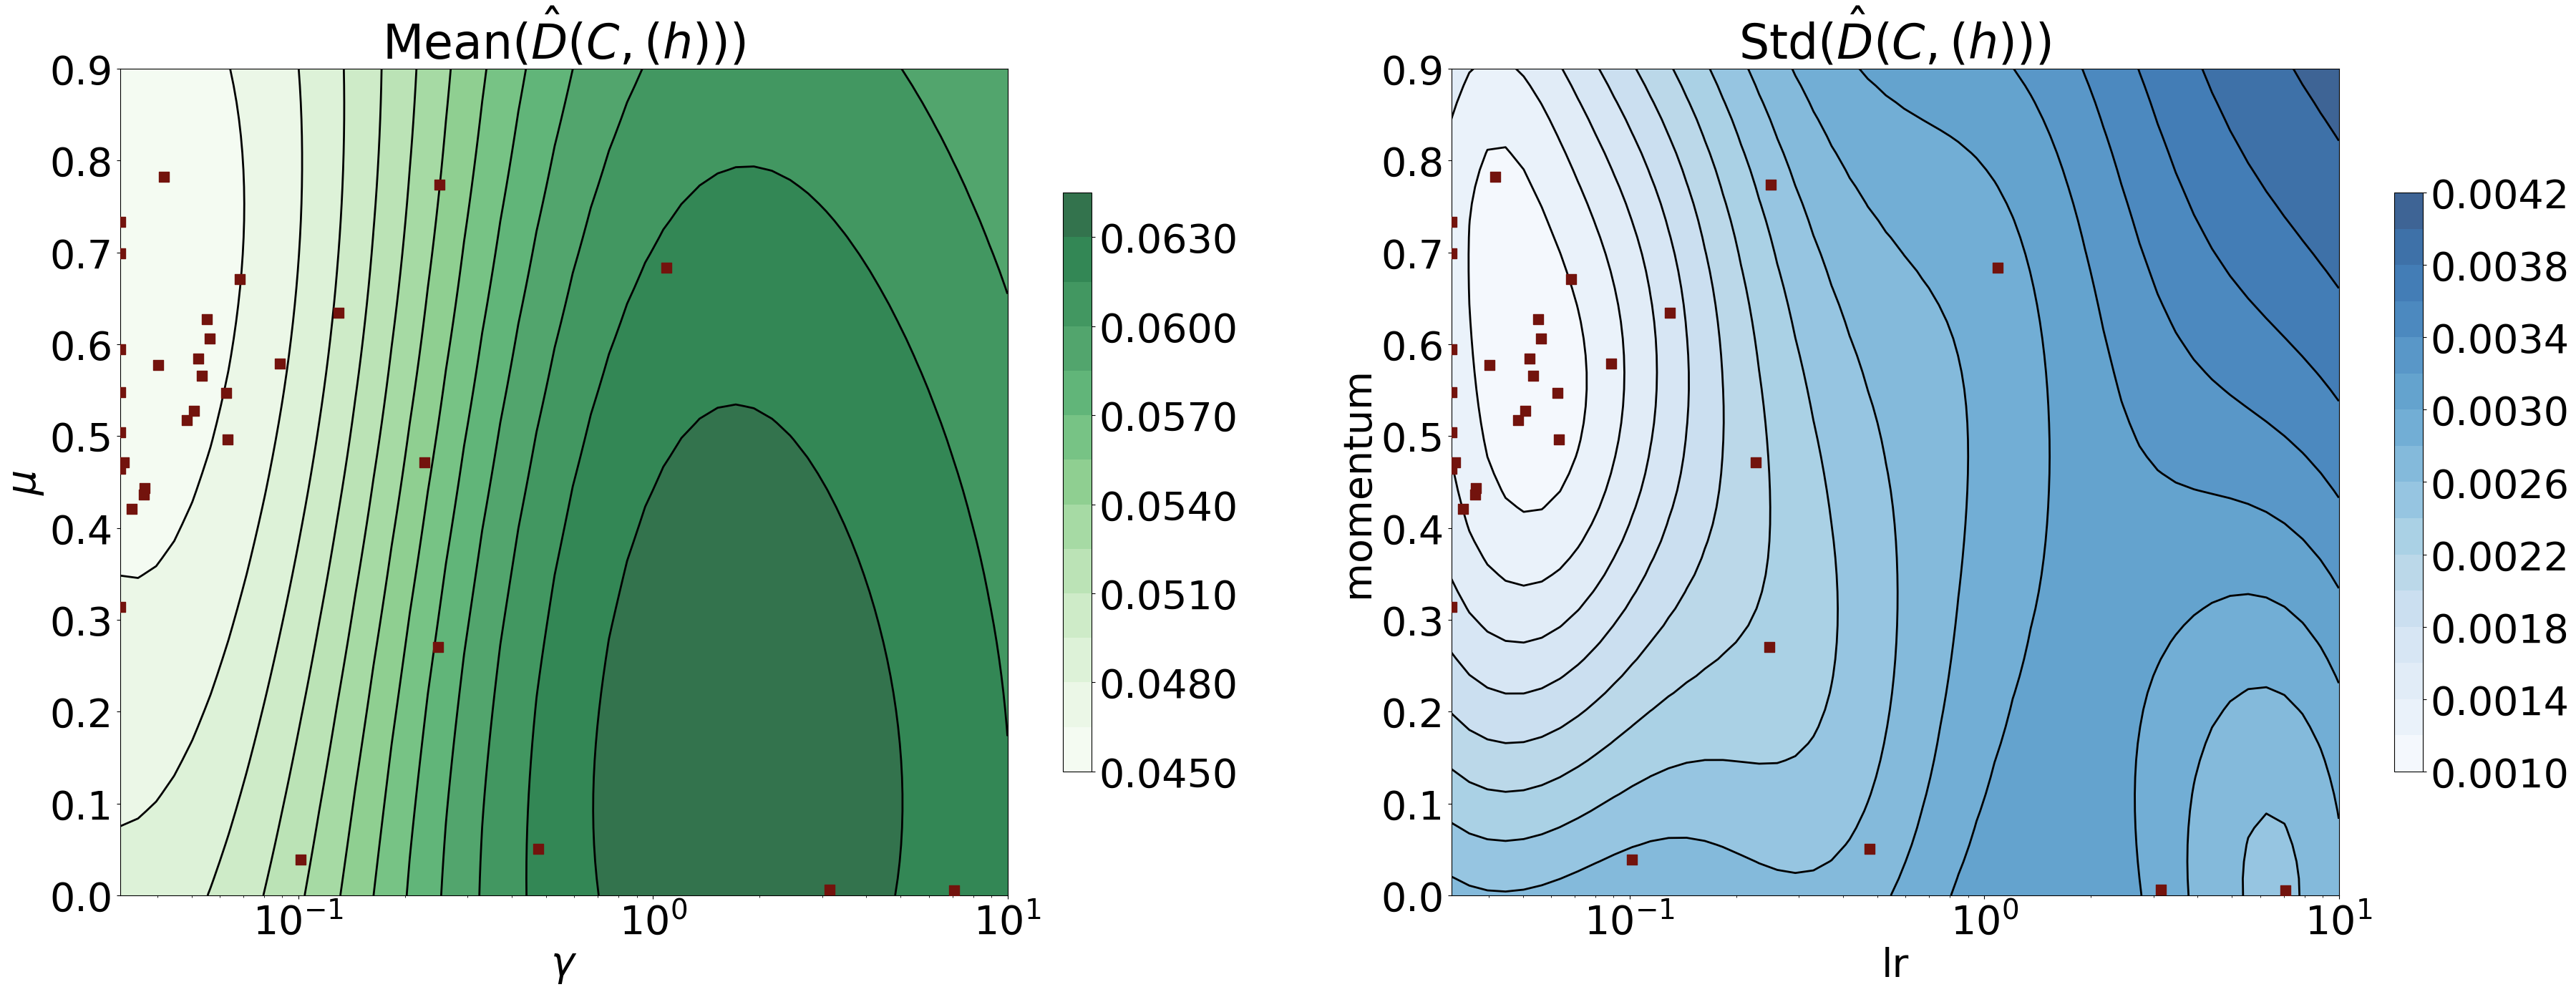

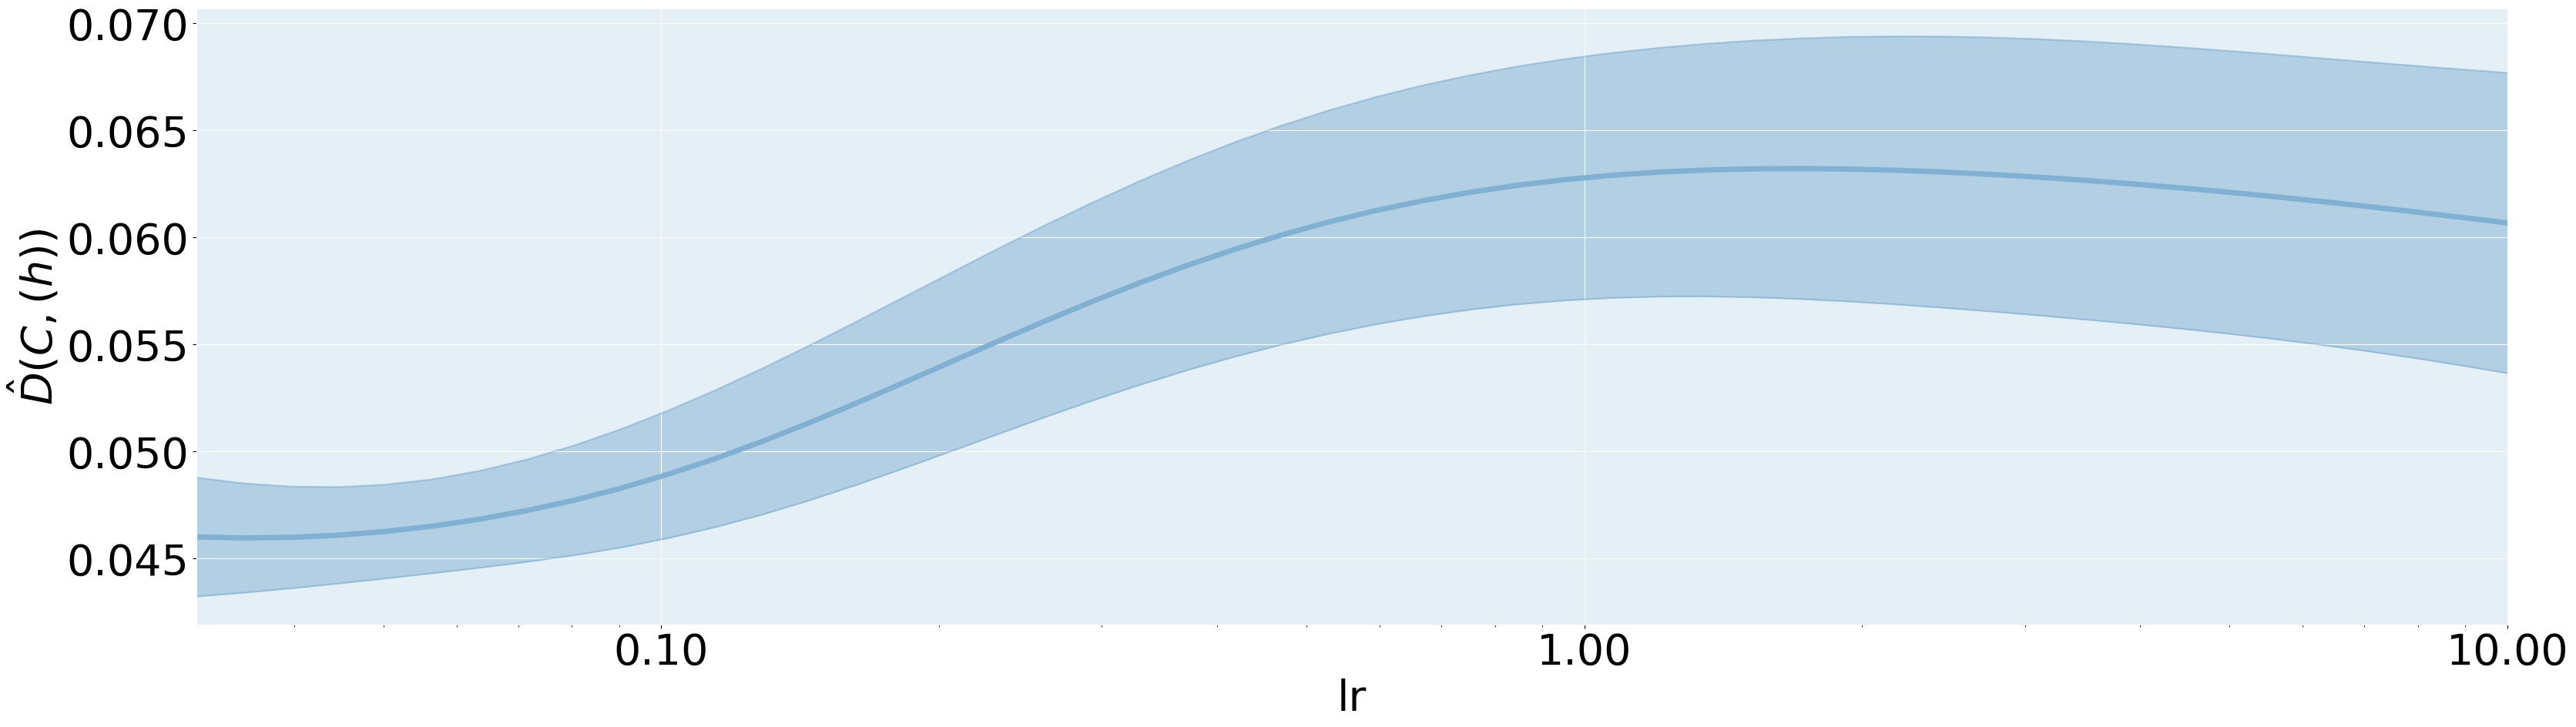

In [2]:
from utils.plots import plot_contour, plot_slice

tuning_model = ho_fmn.get_tuning_model()

# Change param_x, param_y accordingly
plot_contour(model=tuning_model, param_x='lr', param_y='momentum', metric_name="distance")
plot_slice(model=tuning_model, param_name='lr', metric_name="distance")

## Testing the tuned FMN version against the baseline
We can now test the attack performance, in terms of the adversarial robustness, of the tuned FMN version against the baseline (LL, SGD, CALR). We chose to test both the attacks with 128 CIFAR10 samples (different from the tuning set), and 200 steps.

In [ ]:
tuning_bs = batch_size
tuning_trials = trials
tuning_samples = tuning_bs*tuning_trials

batch_size = 128
attack_steps = 200

model_id = 8
model, dataset, model_name, _ = load_data(model_id=model_id)

subset_indices = list(range(tuning_samples, tuning_samples + batch_size))
dataset_frac = torch.utils.data.Subset(dataset, subset_indices)

print(f"Samples: {len(subset_indices)}")

dataloader = DataLoader(
    dataset=dataset_frac,
    batch_size=batch_size,
    shuffle=False
)

# Extract the optimizer and scheduler config from the best params dictionary
optimizer_config, scheduler_config = ho_fmn.parametrization_to_configs(best_parameters,
                                                                       batch_size=batch_size,
                                                                       steps=attack_steps)

model.eval()
model.to(device)

baseline_attack = FMN(
        model=model,
        steps=attack_steps,
        loss='LL',
        optimizer='SGD',
        scheduler='CALR',
        device=device
        )

tuned_attack = FMN(
        model=model,
        steps=attack_steps,
        loss=loss,
        optimizer=optimizer,
        scheduler=scheduler,
        optimizer_config=optimizer_config,
        scheduler_config=scheduler_config,
        device=device
        )

In [ ]:
# Testing on a single batch
images, labels = next(iter(dataloader))

baseline_best_adv = baseline_attack.forward(images=images, labels=labels)
tuned_best_adv = tuned_attack.forward(images=images, labels=labels)

Clean accuracy:
	0.8125
Baseline Robust accuracy (at 8/255):
	0.609375
Robust accuracy (at 8/255):
	0.5703125


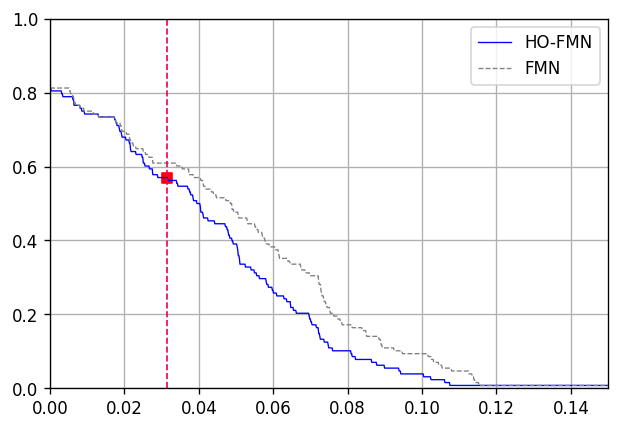

In [47]:
from src.utils.plots import compare_adv_robustness

compare_adv_robustness(baseline_best_adv, tuned_best_adv, images)

The plot above shows the robustness-perturbation curves for both the baseline and the tuned FMN versions. When the blue line (HO-FMN tuned attack) lies below the grey line (baseline FMN) means that the tuning process has increased the strength of the attack; this translates in a reduction of the adversarial robustness of the model, for the same perturbation budget.

## Some examples of adversarial examples obtained with the tuned FMN

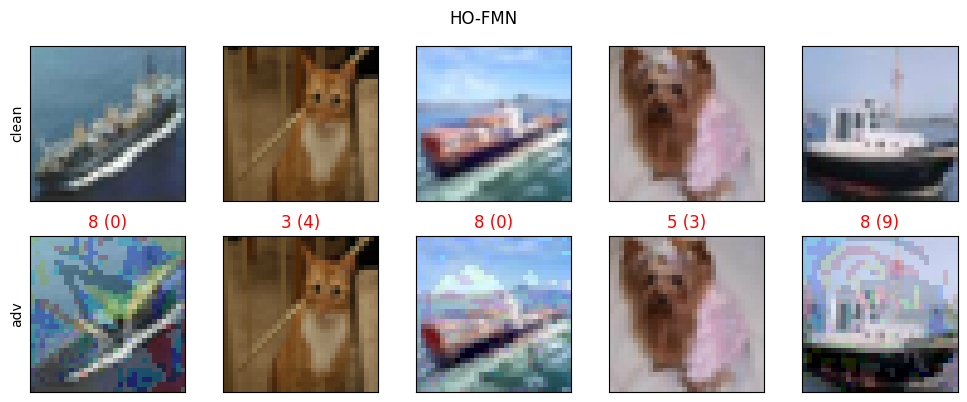

In [50]:
preds = model(tuned_best_adv).argmax(1)

img_shape = (3, 32, 32)
show_image('HO-FMN', images, tuned_best_adv, preds, labels, img_shape=img_shape, n_display=5,)